<a href="https://colab.research.google.com/github/Aishaamalik/Predicting-Product-Return-Probability-in-E-Commerce/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Product Return Probability in E-Commerce


In [7]:
import pandas as pd

df = pd.read_csv("ecommerce_returns_synthetic_data.csv")

df.head()


,Order_ID,Product_ID,User_ID,Order_Date,Return_Date,Product_Category,Product_Price,Order_Quantity,Return_Reason,Return_Status,Days_to_Return,User_Age,User_Gender,User_Location,Payment_Method,Shipping_Method,Discount_Applied
0,ORD00000000,PROD00000000,USER00000000,2023-08-05,2024-08-26,Clothing,411.59,3,Changed mind,Returned,387.0,58,Male,City54,Debit Card,Next-Day,45.27
1,ORD00000001,PROD00000001,USER00000001,2023-10-09,2023-11-09,Books,288.88,3,Wrong item,Returned,31.0,68,Female,City85,Credit Card,Express,47.79
2,ORD00000002,PROD00000002,USER00000002,2023-05-06,NaN,Toys,390.03,5,NaN,Not Returned,NaN,22,Female,City30,Debit Card,Next-Day,26.64
3,ORD00000003,PROD00000003,USER00000003,2024-08-29,NaN,Toys,401.09,3,NaN,Not Returned,NaN,40,Male,City95,PayPal,Next-Day,15.37
4,ORD00000004,PROD00000004,USER00000004,2023-01-16,NaN,Books,110.09,4,NaN,Not Returned,NaN,34,Female,City80,Gift Card,Standard,16.37


# 1: Data Cleaning and Processing

 **Objective**

- Handle missing values

- Encode categorical variables appropriately

- Extract features from dates

- Normalize numerical data

- Select relevant features for modeling

##1.1 Handling Missing Values

In [8]:
df.isnull().sum()


,0
Order_ID,0
Product_ID,0
User_ID,0
Order_Date,0
Return_Date,4948
Product_Category,0
Product_Price,0
Order_Quantity,0
Return_Reason,4948
Return_Status,0


- Return_Date, Return_Reason, and Days_to_Return have missing values.

- These are expected for orders that were not returned (i.e., Return_Status == 'Not Returned').

We’ll fill them with placeholder values

In [20]:
df.loc[df['Return_Status'] == 'Not Returned', 'Return_Date'] = 'Not Returned'
df.loc[df['Return_Status'] == 'Not Returned', 'Return_Reason'] = 'Not Applicable'
df.loc[df['Return_Status'] == 'Not Returned', 'Days_to_Return'] = 0


##1.2 Encode Categorical Variables

 - One-hot encoding: Nominal variables with multiple values (e.g., Product_Category, Payment_Method, Shipping_Method)

- Label encoding: Binary categories (e.g., User_Gender)


### a: One-Hot Encoding (for nominal categorical features)

In [52]:
nominal_cols = ['Product_Category', 'Payment_Method', 'Shipping_Method', 'User_Location']

nominal_cols_existing = [col for col in nominal_cols if col in df.columns]

if nominal_cols_existing:
    df = pd.get_dummies(df, columns=nominal_cols_existing, drop_first=True)
else:
    print("All nominal columns have already been encoded.")


All nominal columns have already been encoded.


### b: Label Encoding (for binary categorical features)

In [23]:
df['User_Gender'] = df['User_Gender'].map({'Male': 1, 'Female': 0})


Final Optional Check: See remaining missing values

In [24]:
print(df.isnull().sum())


Order_ID                0
Product_ID              0
User_ID                 0
Order_Date              0
Return_Date             0
                       ..
User_Location_City95    0
User_Location_City96    0
User_Location_City97    0
User_Location_City98    0
User_Location_City99    0
Length: 121, dtype: int64


##1.3 Convert Order_Date to Datetime and Extract Features

In [25]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

df['Order_Month'] = df['Order_Date'].dt.month
df['Order_DayOfWeek'] = df['Order_Date'].dt.dayofweek

df.drop(columns=['Order_Date', 'Return_Date'], inplace=True)


##1.4 Normalize Numerical Features

List of Numerical Columns to Scale

In [41]:
from sklearn.preprocessing import StandardScaler

num_cols = ['Product_Price', 'Order_Quantity', 'User_Age', 'Discount_Applied', 'Days_to_Return']

df['Days_to_Return'] = df['Days_to_Return'].fillna(0)

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


##1.5 Feature Selection



### a: Drop Irrelevant / Highly Correlated Features

We'll remove columns that are:

- Identifiers (Order_ID, User_ID, etc.)

- Dates (Order_Date, Return_Date)

- Highly correlated numerical features (e.g., if correlation > 0.9)

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

irrelevant_cols = ['Order_ID', 'User_ID', 'Product_ID', 'Order_Date', 'Return_Date']
df_cleaned = df.drop(columns=irrelevant_cols, errors='ignore')

if 'Return' not in df_cleaned.columns:
    if 'Return_Status' in df_cleaned.columns:
        df_cleaned['Return'] = df_cleaned['Return_Status'].map({'Returned': 1, 'Not Returned': 0})

df_cleaned = df_cleaned.drop(columns=['Return_Status'], errors='ignore')

corr_matrix = df_cleaned.select_dtypes(include=['int64', 'float64']).corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

df_cleaned = df_cleaned.drop(columns=to_drop, errors='ignore')

print(f"Dropped for high correlation: {to_drop}")


Dropped for high correlation: []



### b: Feature Importance using Random Forest



Top 15 Important Features:
                          Feature  Importance
5                Discount_Applied    0.114139
0                   Product_Price    0.114044
3                        User_Age    0.094540
2                  Days_to_Return    0.079197
114                   Order_Month    0.068835
115               Order_DayOfWeek    0.055731
1                  Order_Quantity    0.046083
14       Shipping_Method_Standard    0.018187
13       Shipping_Method_Next-Day    0.017285
12          Payment_Method_PayPal    0.016184
10      Payment_Method_Debit Card    0.015744
11       Payment_Method_Gift Card    0.015544
8           Product_Category_Home    0.014902
6       Product_Category_Clothing    0.014858
7    Product_Category_Electronics    0.014852


<ipython-input-57-fb318cede318>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')


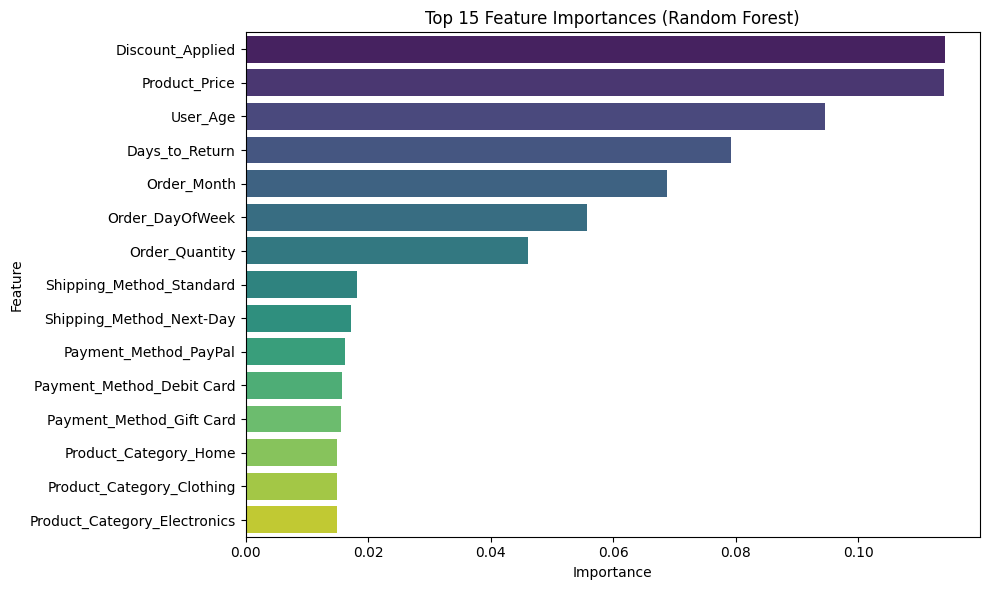

In [57]:
from sklearn.ensemble import RandomForestClassifier

X = df_cleaned.drop(columns=['Return'])
y = df_cleaned['Return']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 15 Important Features:")
print(importances.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


**downloading df_cleaned**

In [59]:
df_cleaned.to_csv('cleaned_ecommerce_data.csv', index=False)

from google.colab import files
files.download('cleaned_ecommerce_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

#2: Data Understanding & Exploration

## 1: Dataset


###1.1 Load and Inspect the Cleaned Dataset


In [61]:
print(" Number of Rows and Columns:", df_cleaned.shape)

print("\nColumn Names:")
print(df_cleaned.columns.tolist())


 Number of Rows and Columns: (10000, 117)

Column Names:
['Product_Price', 'Order_Quantity', 'Days_to_Return', 'User_Age', 'User_Gender', 'Discount_Applied', 'Product_Category_Clothing', 'Product_Category_Electronics', 'Product_Category_Home', 'Product_Category_Toys', 'Payment_Method_Debit Card', 'Payment_Method_Gift Card', 'Payment_Method_PayPal', 'Shipping_Method_Next-Day', 'Shipping_Method_Standard', 'User_Location_City10', 'User_Location_City100', 'User_Location_City11', 'User_Location_City12', 'User_Location_City13', 'User_Location_City14', 'User_Location_City15', 'User_Location_City16', 'User_Location_City17', 'User_Location_City18', 'User_Location_City19', 'User_Location_City2', 'User_Location_City20', 'User_Location_City21', 'User_Location_City22', 'User_Location_City23', 'User_Location_City24', 'User_Location_City25', 'User_Location_City26', 'User_Location_City27', 'User_Location_City28', 'User_Location_City29', 'User_Location_City3', 'User_Location_City30', 'User_Location_Cit

###1.2 Understand Feature Data Types & Missing Values

In [62]:
print("Feature Data Types & Missing Value Summary:")
df_cleaned.info()


Feature Data Types & Missing Value Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 117 entries, Product_Price to Return
dtypes: bool(108), float64(6), int32(2), int64(1)
memory usage: 1.6 MB


###1.3 Preview the Data (First Few Rows)

In [63]:
df_cleaned.head()


,Product_Price,Order_Quantity,Days_to_Return,User_Age,User_Gender,Discount_Applied,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Home,Product_Category_Toys,...,User_Location_City93,User_Location_City94,User_Location_City95,User_Location_City96,User_Location_City97,User_Location_City98,User_Location_City99,Order_Month,Order_DayOfWeek,Return
0,1.114392,-0.004336,1.823908,0.901627,NaN,1.411842,True,False,False,False,...,False,False,False,False,False,False,False,8,5,0
1,0.255540,-0.004336,0.142911,1.554742,NaN,1.587297,False,False,False,False,...,False,False,False,False,False,False,False,10,0,1
2,0.963493,1.417410,-0.003468,-1.449591,NaN,0.114731,False,False,False,True,...,False,False,False,False,False,False,False,5,5,1
3,1.040902,-0.004336,-0.003468,-0.273982,NaN,-0.669942,False,False,False,True,...,False,False,True,False,False,False,False,8,3,0
4,-0.995819,0.706537,-0.003468,-0.665852,NaN,-0.600317,False,False,False,False,...,False,False,False,False,False,False,False,1,0,1


### 1.4 Understand the Target Variable Return (Binary: Yes / No)

 Target Variable - 'Return' (0 = Not Returned, 1 = Returned):

Return
1    5010
0    4990
Name: count, dtype: int64

 Percentage Distribution:
Return
1    50.1
0    49.9
Name: proportion, dtype: float64


<ipython-input-67-253b2a4e66c9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Return', data=df_cleaned, palette='pastel', legend=False)
<ipython-input-67-253b2a4e66c9>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


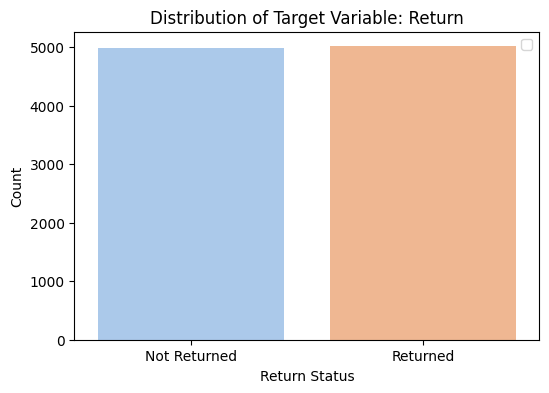

In [67]:
print(" Target Variable - 'Return' (0 = Not Returned, 1 = Returned):\n")
print(df_cleaned['Return'].value_counts())

print("\n Percentage Distribution:")
print(df_cleaned['Return'].value_counts(normalize=True) * 100)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='Return', data=df_cleaned, palette='pastel', legend=False)
plt.title('Distribution of Target Variable: Return')
plt.xticks([0, 1], ['Not Returned', 'Returned'])
plt.ylabel('Count')
plt.xlabel('Return Status')
plt.legend()
plt.show()


 Balanced Dataset: The class distribution is nearly perfectly balanced, meaning:

- No need for oversampling (SMOTE) or undersampling.

- You can train classification models directly without worrying about imbalance bias.